<a href="https://colab.research.google.com/github/Sne-ha-stack/Stroke-Prediction/blob/main/stroke_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_curve, auc, RocCurveDisplay
from keras.preprocessing import image
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dense, Dropout, Activation)
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up constants
data_dir = '/content/drive/MyDrive/STROKE/Dataset Stroke'
categories = ['noStroke_data', 'stroke_data']
img_size = 48  # Resizing images to 48x48
batch_size = 32
num_classes = 2

In [ ]:
# Helper function to load and preprocess the dataset
def load_data(data_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)  # 0 for no stroke, 1 for stroke
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale images
                img = cv2.resize(img, (img_size, img_size))
                data.append([img, label])
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    return data

In [ ]:
# Load dataset
data = load_data(data_dir, categories, img_size)
np.random.shuffle(data)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/STROKE/Dataset Stroke/noStroke_data'

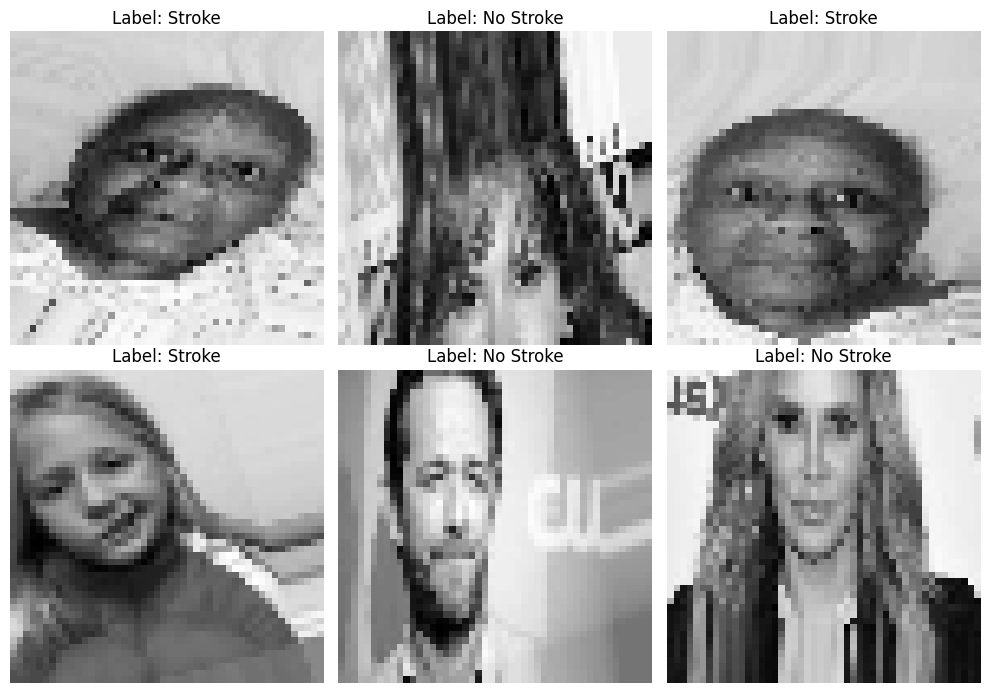

In [ ]:
# Display the first 5-6 images with labels
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # Adjust the grid size as needed
axes = axes.ravel()

for i in range(6):  # Display the first 6 images
    img, label = data[i]
    axes[i].imshow(img, cmap='gray')  # Show the image
    axes[i].set_title(f"Label: {'Stroke' if label == 1 else 'No Stroke'}")  # Set the title with the label
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
# Split features and labels
x_data = np.array([item[0] for item in data]).reshape(-1, img_size, img_size, 1) / 255.0  # Normalize
y_data = np.array([item[1] for item in data])
y_data = tf.keras.utils.to_categorical(y_data, num_classes)

In [ ]:
# Split the dataset
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1613, 48, 48, 1), (346, 48, 48, 1), (1613, 2), (346, 2))

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,  # Increased rotation range
    zoom_range=0.3,     # Increased zoom range
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'  # Added fill_mode for better image handling
)

datagen.fit(x_train)

In [ ]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced Dense units
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Adjust class weights#
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Compute class weights based on the distribution of the data#
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(np.argmax(y_data, axis=1)),
                                     y=np.argmax(y_data, axis=1))

In [ ]:
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.1018164435946463, 1: 0.9154090548054011}


In [ ]:
# Compile the model with sensitivity as a monitored metric
from tensorflow.keras.metrics import Recall

In [ ]:
# Compile the model with a higher learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # Learning rate remains the same
              loss='categorical_crossentropy',
              metrics=['accuracy', Recall()])  # Adding Recall to metrics

In [ ]:
# Callbacks for early stopping and learning rate adjustment
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4)


In [ ]:
# Train the model with class weights
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val),
                    epochs=30,
                    callbacks=[early_stopping, lr_scheduler],
                    class_weight=class_weights)  # Use class weights during training

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.6159 - loss: 3.1597 - recall: 0.5606 - val_accuracy: 0.4942 - val_loss: 2.5091 - val_recall: 0.4942 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.7301 - loss: 2.2053 - recall: 0.6340 - val_accuracy: 0.4942 - val_loss: 2.0087 - val_recall: 0.4942 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 295ms/step - accuracy: 0.7904 - loss: 1.6587 - recall: 0.7469 - val_accuracy: 0.4942 - val_loss: 1.7619 - val_recall: 0.4942 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.7885 - loss: 1.3584 - recall: 0.7297 - val_accuracy: 0.5058 - val_loss: 1.4862 - val_recall: 0.5058 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 0.7999 - loss: 1.1395 - recall: 0.7320 - val_accuracy: 0.5058 - val_loss: 1.5533 - val_recall: 0.5058 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - a

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_sensitivity = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Sensitivity (Recall): {test_sensitivity * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5675 - loss: 1.4551 - recall: 0.5675
Test Accuracy: 56.65%
Test Sensitivity (Recall): 56.65%


In [ ]:
# Threshold adjustment for predictions
y_pred_prob = model.predict(x_test)[:, 1]  # Get probabilities for the 'stroke' class
threshold = 0.3  # Lowering the threshold to improve sensitivity
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [ ]:
# Calculate sensitivity (Recall)
#y_pred = np.argmax(model.predict(x_test), axis=1)
#y_true = np.argmax(y_test, axis=1)
#test_sensitivity = recall_score(y_true, y_pred)
#print(f"Test Sensitivity (Recall): {test_sensitivity * 100:.2f}%")

In [ ]:
# Recalculate confusion matrix and metrics
y_true = np.argmax(y_test, axis=1)
conf_matrix_adjusted = confusion_matrix(y_true, y_pred_adjusted)
print("Confusion Matrix (Adjusted Threshold):\n", conf_matrix_adjusted)

Confusion Matrix (Adjusted Threshold):
 [[  0 150]
 [  0 196]]


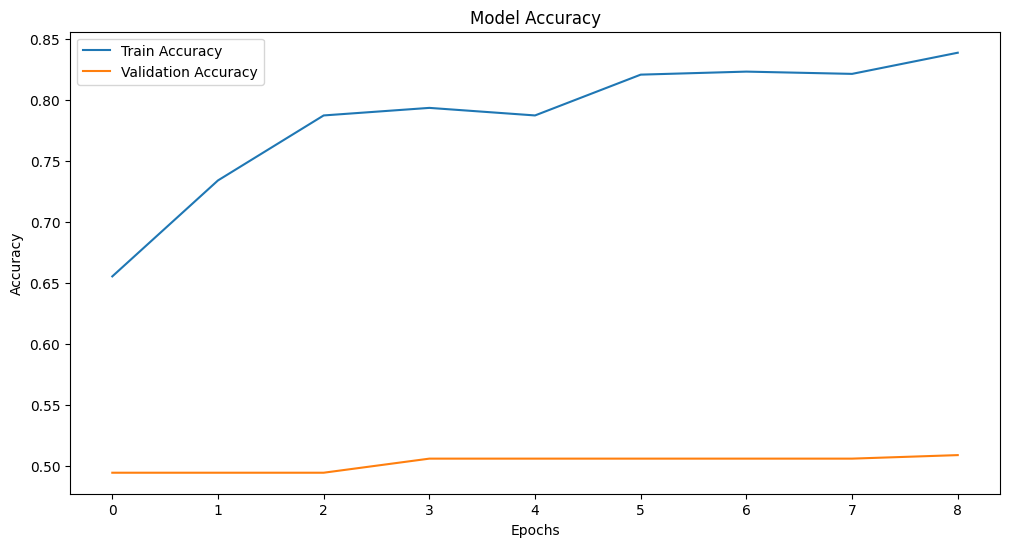

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

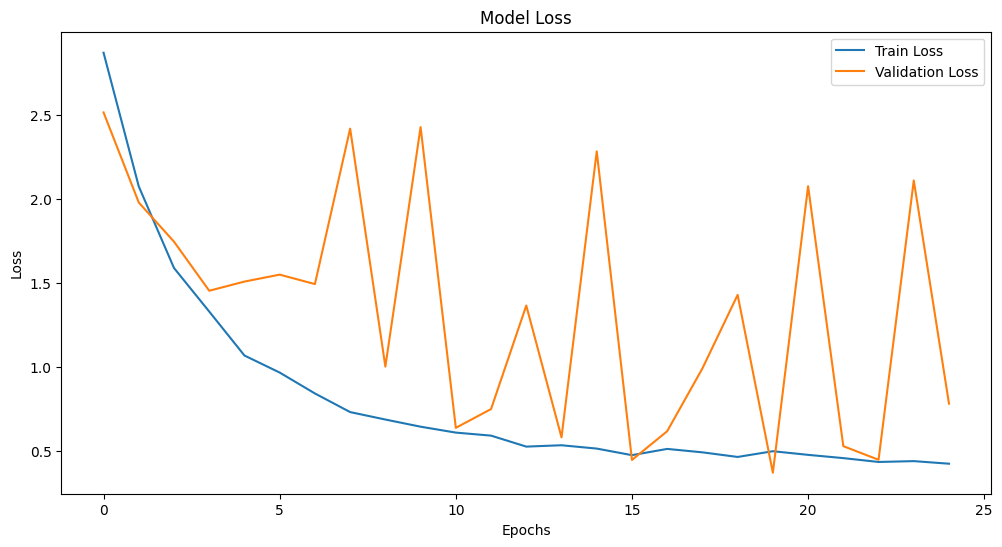

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# AUC and ROC Curve
fpr, tpr, _ = roc_curve(y_true, model.predict(x_test)[:, 1])  # For binary classification (e.g., 1 vs 0)
roc_auc = auc(fpr, tpr)
print(f"Test AUC: {roc_auc:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Test AUC: 0.99


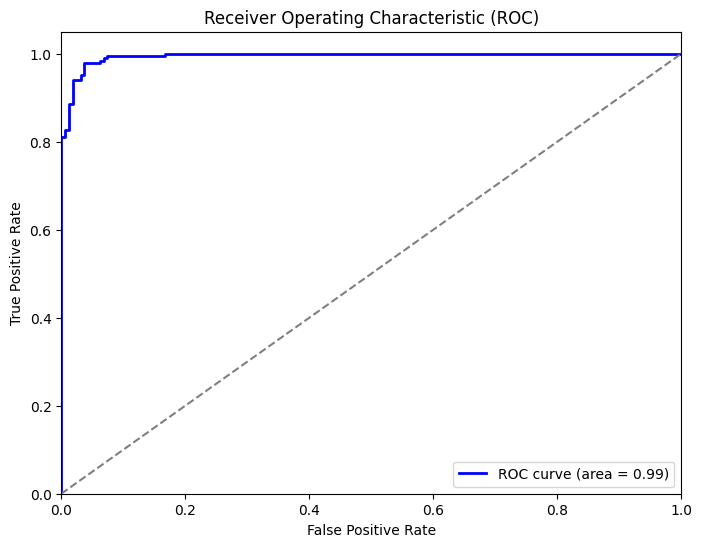

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

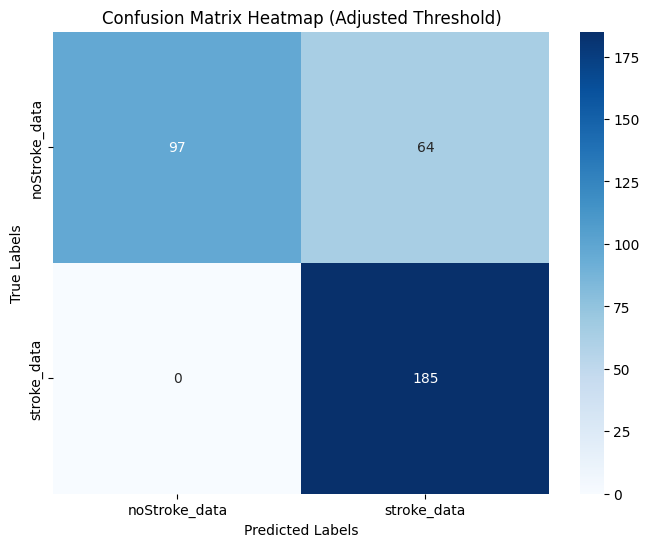

In [ ]:
# Heatmap for the adjusted confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix Heatmap (Adjusted Threshold)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
def predict_stroke(dir_path, model, img_size, num_images=5):
    count = 0
    for img_name in os.listdir(dir_path):
        if count >= num_images:  # Stop after processing the specified number of images
            break

        img_path = os.path.join(dir_path, img_name)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_size, img_size), color_mode='grayscale')

        # Display the image
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicting stroke for {img_name}")
        plt.axis('off')  # Hide axes for better visual
        plt.show()

        # Convert image to array and normalize
        x = image.img_to_array(img) / 255.0  # Normalize pixel values to [0,1]
        x = np.expand_dims(x, axis=0)  # Add batch dimension

        # Predict stroke using the trained model
        prediction = np.argmax(model.predict(x))

        # Print the prediction result
        if prediction == 0:
            print(f"Result for {img_name}: Stroke is NOT detected.")
        else:
            print(f"Result for {img_name}: Stroke is detected.")

        count += 1


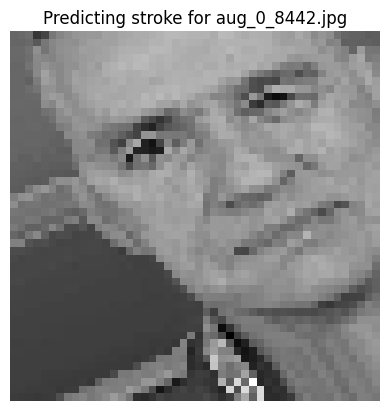

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Result for aug_0_8442.jpg: Stroke is detected.


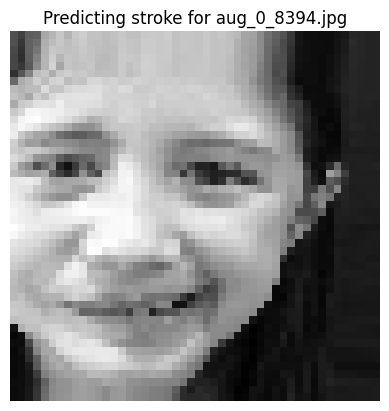

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Result for aug_0_8394.jpg: Stroke is detected.


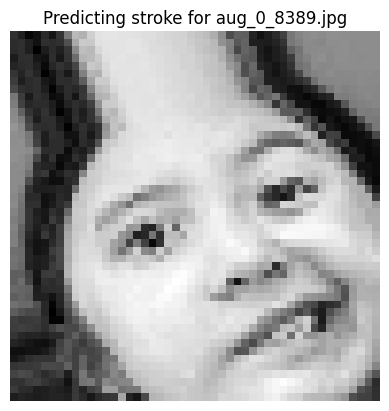

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Result for aug_0_8389.jpg: Stroke is detected.


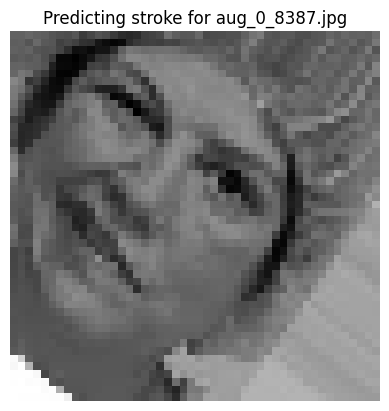

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Result for aug_0_8387.jpg: Stroke is detected.


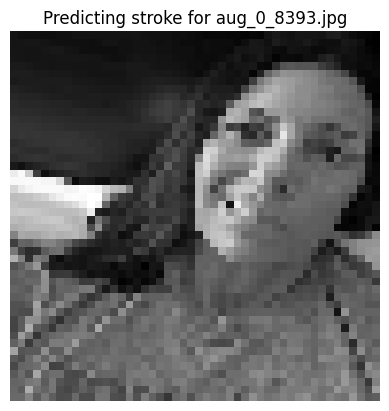

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Result for aug_0_8393.jpg: Stroke is detected.


In [ ]:
predict_stroke("/content/drive/MyDrive/New folder", model, img_size, num_images=5)

In [ ]:
# Assuming `model` is your trained model
model.save('model.h5')